# Preparation du Dataset OCR - Fusion de Sources Multiples

**Objectif:** Fusionner trois sources de donnees distinctes pour creer un dataset d'entrainement unifie pour un modele OCR robuste.

**Sources:**
1. Dataset Drive (images brutes 28x28)
2. Dataset Kaggle (CSV format)
3. Dataset EMNIST (via torchvision)

**Pipeline:**
- Ingestion et standardisation
- Visualisation et verification
- Fusion et normalisation
- Export des tenseurs finaux

## 1. Imports et Configuration

In [1]:
# Imports standards
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Imports pour le traitement d'images
from PIL import Image
import cv2

# Imports pour les datasets
import kagglehub
import torchvision
from torchvision import datasets, transforms

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Environnement configure avec succes")
print(f"Versions: numpy={np.__version__}, pandas={pd.__version__}")

Environnement configure avec succes
Versions: numpy=2.0.2, pandas=2.2.2


## 2. Fonctions Utilitaires

In [2]:
def standardize_image(image, target_size=(28, 28)):
    """
    Standardise une image: conversion en niveaux de gris, redimensionnement 28x28.

    Args:
        image: Image PIL, array numpy, ou chemin vers une image
        target_size: Tuple (hauteur, largeur) pour le redimensionnement

    Returns:
        Array numpy de dimension (28, 28) normalise entre 0 et 255
    """
    # Conversion en array numpy si necessaire
    if isinstance(image, str):
        image = Image.open(image)

    if isinstance(image, Image.Image):
        # Conversion en niveaux de gris
        if image.mode != 'L':
            image = image.convert('L')
        image = np.array(image)

    # Verifier que l'image est en 2D
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Redimensionnement si necessaire
    if image.shape != target_size:
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

    return image.astype(np.uint8)


def visualize_samples(X, y, dataset_name, n_samples=5):
    """
    Affiche une grille d'images aleatoires avec leurs labels.

    Args:
        X: Array d'images (N, 28, 28)
        y: Array de labels (N,)
        dataset_name: Nom du dataset pour le titre
        n_samples: Nombre d'echantillons a afficher
    """
    indices = np.random.choice(len(X), min(n_samples, len(X)), replace=False)

    fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
    fig.suptitle(f'Echantillons aleatoires - {dataset_name}', fontsize=14, fontweight='bold')

    for idx, ax in enumerate(axes):
        img_idx = indices[idx]
        ax.imshow(X[img_idx], cmap='gray')
        label_char = chr(65 + int(y[img_idx]))  # Conversion 0-25 vers A-Z
        ax.set_title(f'Label: {label_char} ({int(y[img_idx])})')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def plot_class_distribution(y, dataset_name):
    """
    Affiche la distribution des classes sous forme d'histogramme.

    Args:
        y: Array de labels (N,)
        dataset_name: Nom du dataset pour le titre
    """
    labels_count = Counter(y)
    labels_sorted = sorted(labels_count.items())

    labels = [chr(65 + int(k)) for k, v in labels_sorted]
    counts = [v for k, v in labels_sorted]

    plt.figure(figsize=(14, 5))
    bars = plt.bar(labels, counts, color='steelblue', edgecolor='black')
    plt.xlabel('Lettres (A-Z)', fontsize=12, fontweight='bold')
    plt.ylabel('Nombre d\'echantillons', fontsize=12, fontweight='bold')
    plt.title(f'Distribution des classes - {dataset_name}', fontsize=14, fontweight='bold')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)

    # Afficher les valeurs au-dessus des barres
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

    print(f"\nStatistiques {dataset_name}:")
    print(f"  - Nombre total d'echantillons: {len(y)}")
    print(f"  - Nombre de classes: {len(labels_count)}")
    print(f"  - Min echantillons par classe: {min(counts)}")
    print(f"  - Max echantillons par classe: {max(counts)}")
    print(f"  - Moyenne echantillons par classe: {np.mean(counts):.1f}")


def normalize_labels(labels, source_type='default'):
    """
    Normalise les labels pour qu'ils soient dans l'intervalle [0, 25] pour A-Z.

    Args:
        labels: Array de labels
        source_type: Type de source ('emnist' commence a 1, autres a 0)

    Returns:
        Array de labels normalises [0, 25]
    """
    labels = np.array(labels, dtype=np.int32)

    if source_type == 'emnist':
        # EMNIST 'letters' commence a 1 pour 'A'
        labels = labels - 1

    # Verification que tous les labels sont dans [0, 25]
    assert np.all((labels >= 0) & (labels <= 25)), \
        f"Labels hors intervalle detectes: min={labels.min()}, max={labels.max()}"

    return labels


print("Fonctions utilitaires chargees avec succes")

Fonctions utilitaires chargees avec succes


## 3. Chargement Dataset Drive (Images Brutes)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

def load_drive_dataset(zip_path, extract_dir='./data_temp'):
    """
    Charge le dataset depuis Google Drive (fichier ZIP).

    Args:
        zip_path: Chemin vers le fichier ZIP
        extract_dir: Repertoire d'extraction temporaire

    Returns:
        X_drive: Array (N, 28, 28) d'images
        y_drive: Array (N,) de labels [0-25]
    """
    print("=" * 60)
    print("CHARGEMENT DATASET DRIVE")
    print("=" * 60)

    # Extraction du ZIP si necessaire
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)

    # Verifier si le dossier contient deja les donnees extraites
    dataset_path = None
    for root, dirs, files in os.walk(extract_dir):
        if 'dataset_handwritten_28x28' in dirs:
            dataset_path = os.path.join(root, 'dataset_handwritten_28x28')
            break

    # Si pas encore extrait, extraire le ZIP
    if dataset_path is None:
        print(f"Extraction du fichier {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print("Extraction terminee")

        # Relocaliser le dossier apres extraction
        for root, dirs, files in os.walk(extract_dir):
            if 'dataset_handwritten_28x28' in dirs:
                dataset_path = os.path.join(root, 'dataset_handwritten_28x28')
                break

    if dataset_path is None:
        raise FileNotFoundError("Dossier 'dataset_handwritten_28x28' introuvable")

    print(f"Dataset localise: {dataset_path}")

    # Chargement des images
    X_list = []
    y_list = []

    # Les dossiers sont nommes A, B, C, ..., Z
    for letter_idx in range(26):
        letter = chr(65 + letter_idx)  # A-Z
        letter_dir = os.path.join(dataset_path, letter)

        if not os.path.exists(letter_dir):
            print(f"Attention: dossier {letter} introuvable")
            continue

        image_files = [f for f in os.listdir(letter_dir)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        print(f"Chargement lettre {letter}: {len(image_files)} images", end='\r')

        for img_file in image_files:
            img_path = os.path.join(letter_dir, img_file)
            try:
                img = standardize_image(img_path)
                X_list.append(img)
                y_list.append(letter_idx)
            except Exception as e:
                print(f"\nErreur lors du chargement de {img_path}: {e}")

    X_drive = np.array(X_list, dtype=np.uint8)
    y_drive = np.array(y_list, dtype=np.int32)

    print(f"\nDataset Drive charge: {X_drive.shape[0]} images")
    print(f"Dimensions: {X_drive.shape}")

    return X_drive, y_drive


# Adapter le chemin selon votre configuration
# Pour Google Colab:
zip_path = '/content/drive/MyDrive/dataset_complet_v2.zip'
# Pour local (decommentez si necessaire):
# zip_path = './dataset_complet_v2.zip'

# Chargement du dataset Drive
X_drive, y_drive = load_drive_dataset(zip_path)


Mounted at /content/drive
CHARGEMENT DATASET DRIVE
Extraction du fichier /content/drive/MyDrive/dataset_complet_v2.zip...
Extraction terminee
Dataset localise: ./data_temp/dataset_handwritten_28x28

Dataset Drive charge: 359000 images
Dimensions: (359000, 28, 28)


### Visualisation Dataset Drive

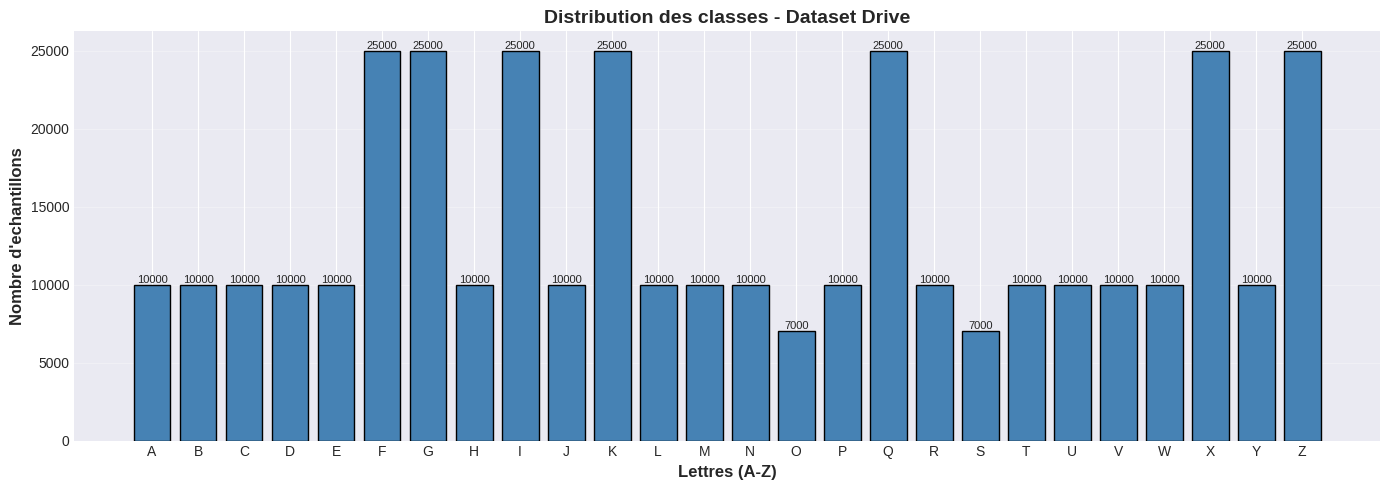


Statistiques Dataset Drive:
  - Nombre total d'echantillons: 359000
  - Nombre de classes: 26
  - Min echantillons par classe: 7000
  - Max echantillons par classe: 25000
  - Moyenne echantillons par classe: 13807.7


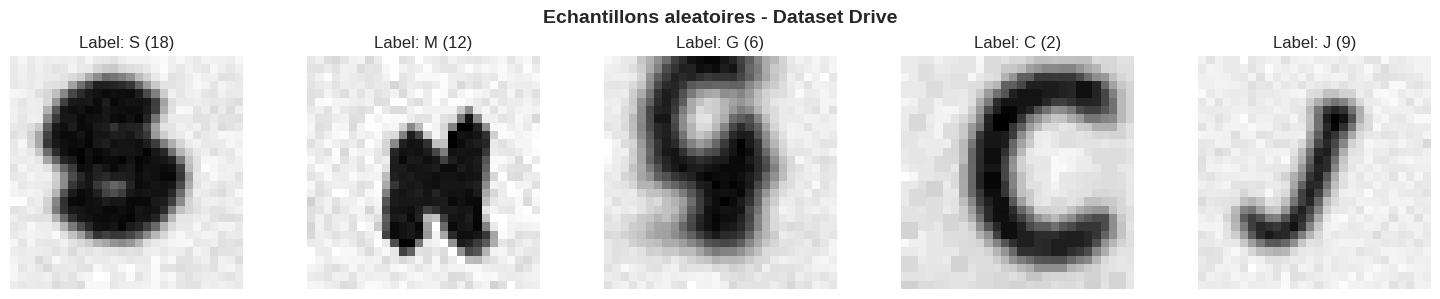

In [5]:
# Visualisation du Dataset Drive

# Distribution des classes
plot_class_distribution(y_drive, "Dataset Drive")

# Echantillons aleatoires
visualize_samples(X_drive, y_drive, "Dataset Drive", n_samples=5)

## 4. Chargement Dataset Kaggle (CSV)

In [4]:
def load_kaggle_dataset():
    """
    Charge le dataset Kaggle via kagglehub.
    Format CSV: premiere colonne = label (0-25), colonnes suivantes = pixels (784 valeurs).

    Returns:
        X_kaggle: Array (N, 28, 28) d'images
        y_kaggle: Array (N,) de labels [0-25]
    """
    print("=" * 60)
    print("CHARGEMENT DATASET KAGGLE")
    print("=" * 60)

    # Telechargement via kagglehub
    print("Telechargement du dataset depuis Kaggle...")
    path = kagglehub.dataset_download("sachinpatel21/az-handwritten-alphabets-in-csv-format")
    print(f"Chemin du dataset: {path}")

    # Localiser le fichier CSV
    csv_files = []
    for root, dirs, files in os.walk(path):
        csv_files.extend([os.path.join(root, f) for f in files if f.endswith('.csv')])

    if not csv_files:
        raise FileNotFoundError("Aucun fichier CSV trouve dans le dataset Kaggle")

    print(f"Fichiers CSV trouves: {len(csv_files)}")
    for csv_file in csv_files:
        print(f"  - {os.path.basename(csv_file)}")

    # Chargement du CSV principal (generalement A_Z Handwritten Data.csv)
    main_csv = csv_files[0]
    print(f"\nChargement du fichier: {os.path.basename(main_csv)}")

    df = pd.read_csv(main_csv)
    print(f"Dimensions du DataFrame: {df.shape}")
    print(f"Colonnes: {df.columns.tolist()[:5]}... (total: {len(df.columns)})")

    # Extraction des labels (premiere colonne)
    y_kaggle = df.iloc[:, 0].values.astype(np.int32)

    # Extraction des pixels (colonnes restantes: 784 valeurs)
    pixels = df.iloc[:, 1:].values.astype(np.uint8)

    # Reshape en images 28x28
    X_kaggle = pixels.reshape(-1, 28, 28)

    print(f"\nDataset Kaggle charge: {X_kaggle.shape[0]} images")
    print(f"Dimensions: {X_kaggle.shape}")
    print(f"Labels uniques: {np.unique(y_kaggle)}")

    return X_kaggle, y_kaggle


# Execution du chargement
X_kaggle, y_kaggle = load_kaggle_dataset()

CHARGEMENT DATASET KAGGLE
Telechargement du dataset depuis Kaggle...


100%|██████████| 185M/185M [00:01<00:00, 189MB/s]

Extracting files...


Chemin du dataset: /root/.cache/kagglehub/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format/versions/5
Fichiers CSV trouves: 2
  - A_Z Handwritten Data.csv
  - A_Z Handwritten Data.csv

Chargement du fichier: A_Z Handwritten Data.csv
Dimensions du DataFrame: (372450, 785)
Colonnes: ['0', '0.1', '0.2', '0.3', '0.4']... (total: 785)

Dataset Kaggle charge: 372450 images
Dimensions: (372450, 28, 28)
Labels uniques: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


### Visualisation Dataset Kaggle

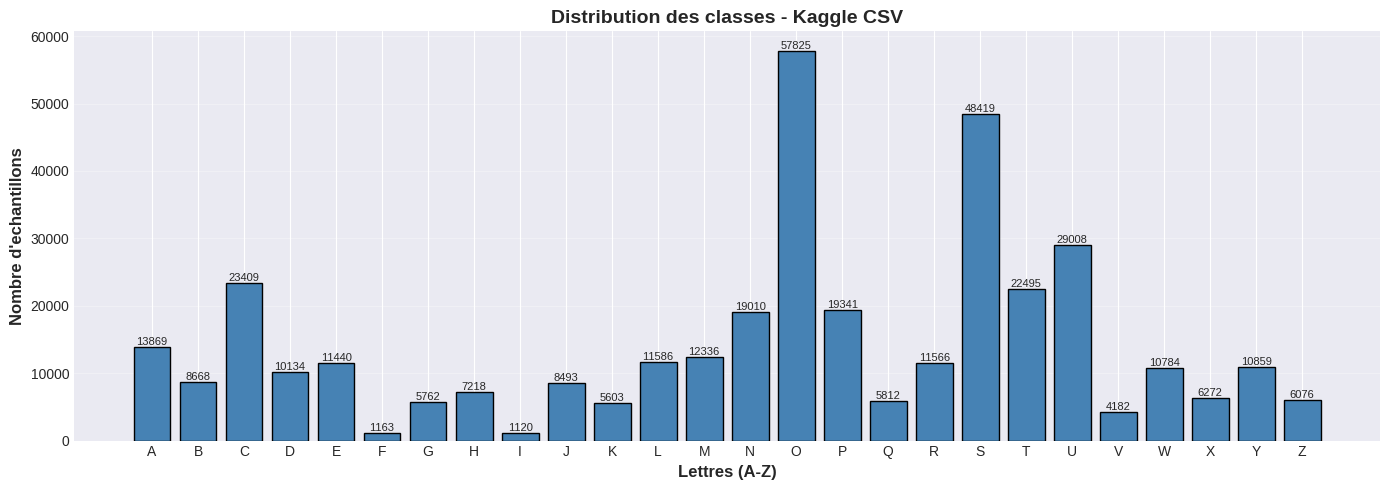


Statistiques Kaggle CSV:
  - Nombre total d'echantillons: 372450
  - Nombre de classes: 26
  - Min echantillons par classe: 1120
  - Max echantillons par classe: 57825
  - Moyenne echantillons par classe: 14325.0


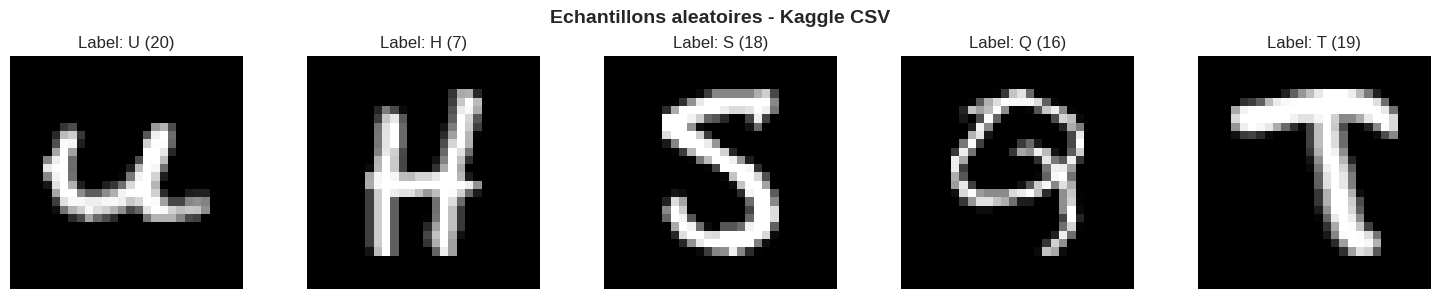

In [6]:
# Distribution des classes
plot_class_distribution(y_kaggle, "Kaggle CSV")

# Echantillons aleatoires
visualize_samples(X_kaggle, y_kaggle, "Kaggle CSV", n_samples=5)

## 5. Chargement Dataset EMNIST

In [7]:
def load_emnist_dataset(data_dir='./data_emnist'):
    """
    Charge le dataset EMNIST via torchvision.
    Attention: Les images EMNIST sont souvent pivotees et les labels commencent a 1.

    Args:
        data_dir: Repertoire de telechargement du dataset

    Returns:
        X_emnist: Array (N, 28, 28) d'images
        y_emnist: Array (N,) de labels [0-25]
    """
    print("=" * 60)
    print("CHARGEMENT DATASET EMNIST")
    print("=" * 60)

    # Telechargement du split 'letters'
    print("Telechargement EMNIST 'letters' (cela peut prendre du temps)...")

    # Dataset d'entrainement
    train_dataset = datasets.EMNIST(
        root=data_dir,
        split='letters',
        train=True,
        download=True,
        transform=transforms.ToTensor()
    )

    # Dataset de test
    test_dataset = datasets.EMNIST(
        root=data_dir,
        split='letters',
        train=False,
        download=True,
        transform=transforms.ToTensor()
    )

    print(f"Train: {len(train_dataset)} images, Test: {len(test_dataset)} images")

    # Fusion train + test
    X_list = []
    y_list = []

    print("Extraction des images d'entrainement...")
    for img, label in train_dataset:
        # Conversion du tenseur en array numpy
        img_array = (img.squeeze().numpy() * 255).astype(np.uint8)

        # EMNIST a souvent besoin d'une rotation/transposition
        # Les images sont pivotees de 90 degres et transposees
        img_array = np.rot90(img_array, k=-1)
        img_array = np.fliplr(img_array)

        X_list.append(img_array)
        y_list.append(label)

    print("Extraction des images de test...")
    for img, label in test_dataset:
        img_array = (img.squeeze().numpy() * 255).astype(np.uint8)
        img_array = np.rot90(img_array, k=-1)
        img_array = np.fliplr(img_array)

        X_list.append(img_array)
        y_list.append(label)

    X_emnist = np.array(X_list, dtype=np.uint8)
    y_emnist = np.array(y_list, dtype=np.int32)

    # Normalisation des labels (EMNIST 'letters' commence a 1 pour 'A')
    y_emnist = normalize_labels(y_emnist, source_type='emnist')

    print(f"\nDataset EMNIST charge: {X_emnist.shape[0]} images")
    print(f"Dimensions: {X_emnist.shape}")
    print(f"Labels uniques: {np.unique(y_emnist)}")

    return X_emnist, y_emnist


# Execution du chargement
X_emnist, y_emnist = load_emnist_dataset()

CHARGEMENT DATASET EMNIST
Telechargement EMNIST 'letters' (cela peut prendre du temps)...


100%|██████████| 562M/562M [00:02<00:00, 256MB/s]


Train: 124800 images, Test: 20800 images
Extraction des images d'entrainement...
Extraction des images de test...

Dataset EMNIST charge: 145600 images
Dimensions: (145600, 28, 28)
Labels uniques: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


### Visualisation Dataset EMNIST

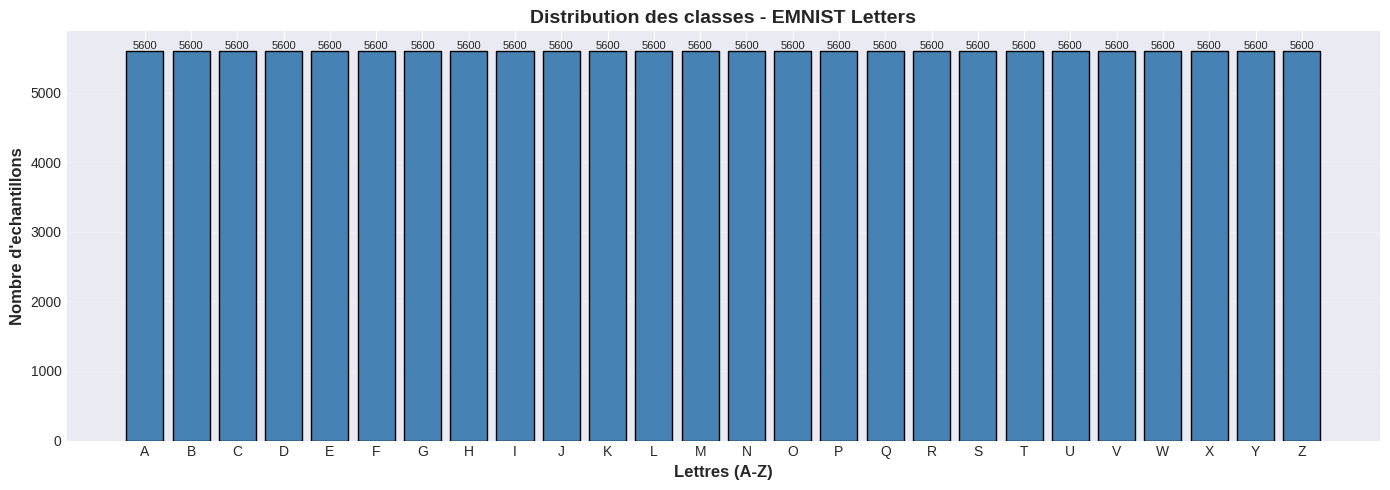


Statistiques EMNIST Letters:
  - Nombre total d'echantillons: 145600
  - Nombre de classes: 26
  - Min echantillons par classe: 5600
  - Max echantillons par classe: 5600
  - Moyenne echantillons par classe: 5600.0


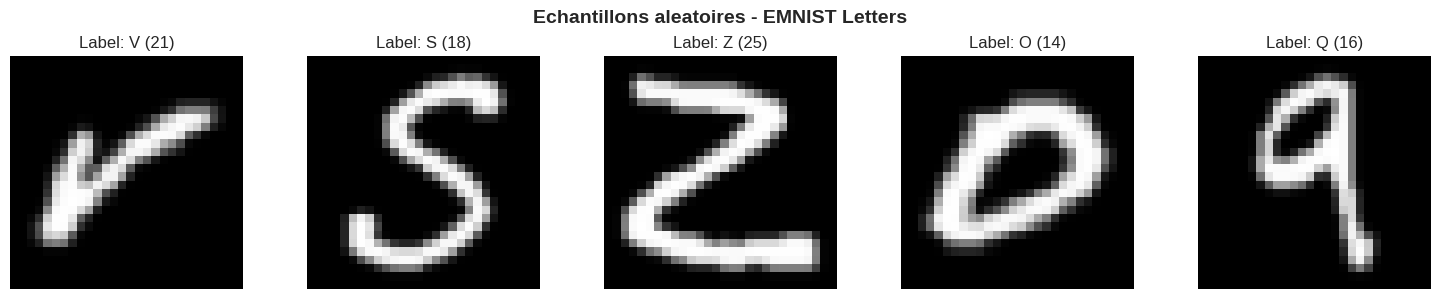

In [8]:
# Distribution des classes
plot_class_distribution(y_emnist, "EMNIST Letters")

# Echantillons aleatoires
visualize_samples(X_emnist, y_emnist, "EMNIST Letters", n_samples=5)

## 7. Fusion des Datasets

In [9]:
def merge_datasets(datasets_dict):
    """
    Fusionne plusieurs datasets en un seul.

    Args:
        datasets_dict: Dictionnaire {nom: (X, y)} des datasets a fusionner

    Returns:
        X_merged: Array concatene de toutes les images
        y_merged: Array concatene de tous les labels
        sources: Array indiquant la source de chaque image
    """
    print("=" * 60)
    print("FUSION DES DATASETS")
    print("=" * 60)

    X_list = []
    y_list = []
    sources_list = []

    for idx, (name, (X, y)) in enumerate(datasets_dict.items()):
        print(f"{name}: {X.shape[0]:,} images")
        X_list.append(X)
        y_list.append(y)
        sources_list.append(np.full(len(y), idx, dtype=np.int32))

    # Concatenation
    X_merged = np.concatenate(X_list, axis=0)
    y_merged = np.concatenate(y_list, axis=0)
    sources = np.concatenate(sources_list, axis=0)

    print(f"\nDataset fusionne: {X_merged.shape[0]:,} images au total")
    print(f"Dimensions: {X_merged.shape}")

    return X_merged, y_merged, sources


# Fusion des trois datasets: Drive, Kaggle et EMNIST
datasets_to_merge = {
    'Drive': (X_drive, y_drive),
    'Kaggle': (X_kaggle, y_kaggle),
    'EMNIST': (X_emnist, y_emnist),
}

X_merged, y_merged, sources = merge_datasets(datasets_to_merge)

FUSION DES DATASETS
Drive: 359,000 images
Kaggle: 372,450 images
EMNIST: 145,600 images

Dataset fusionne: 877,050 images au total
Dimensions: (877050, 28, 28)


### Visualisation du Dataset Fusionne

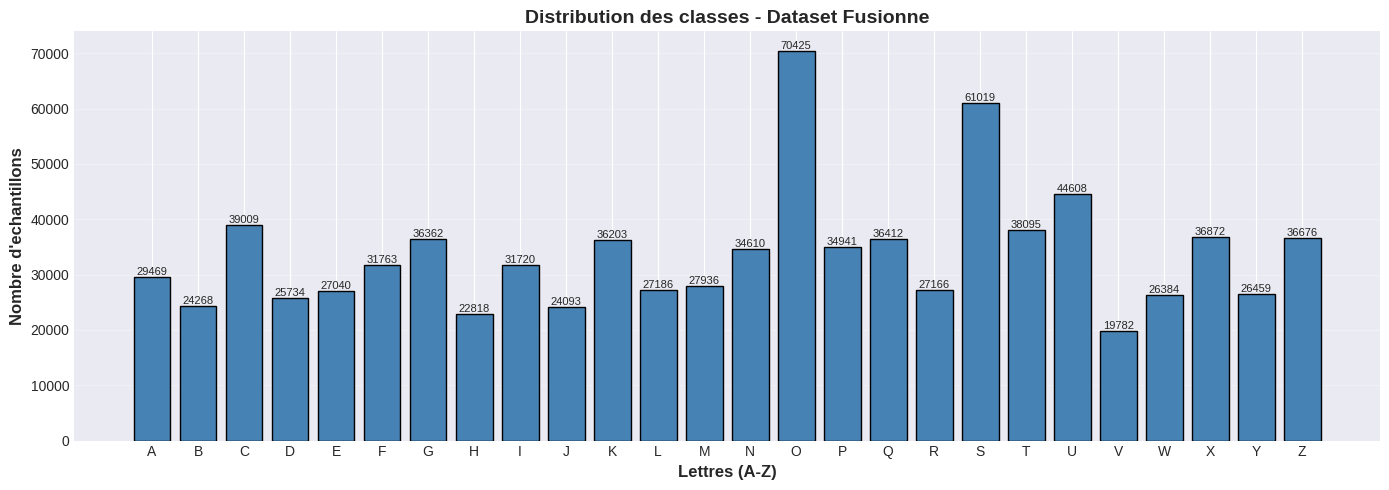


Statistiques Dataset Fusionne:
  - Nombre total d'echantillons: 877050
  - Nombre de classes: 26
  - Min echantillons par classe: 19782
  - Max echantillons par classe: 70425
  - Moyenne echantillons par classe: 33732.7


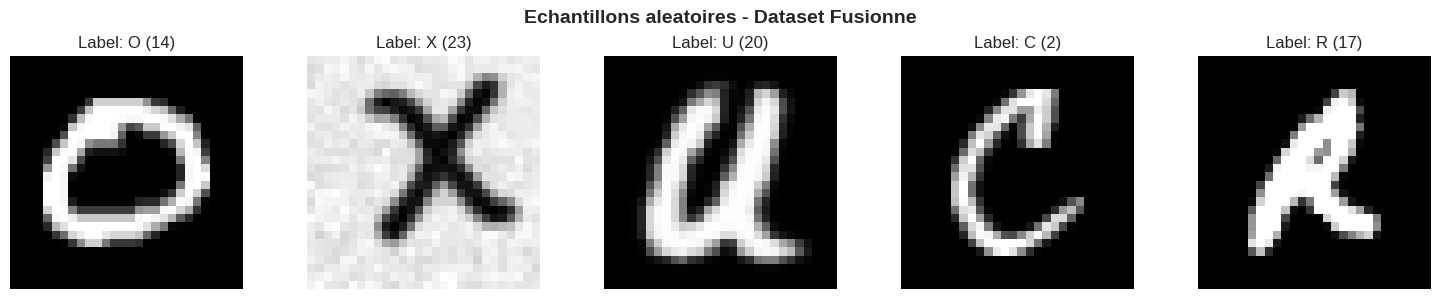


Verification de l'integrite du dataset fusionne:
  - Nombre total d'images: 877050
  - Forme des images: (28, 28)
  - Type de donnees: uint8
  - Plage de valeurs: [0, 255]
  - Labels uniques: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
  - Forme des labels: (877050,)


In [10]:
# Distribution des classes du dataset fusionne
plot_class_distribution(y_merged, "Dataset Fusionne")

# Echantillons aleatoires du dataset fusionne
visualize_samples(X_merged, y_merged, "Dataset Fusionne", n_samples=5)

# Verification de l'integrite
print("\nVerification de l'integrite du dataset fusionne:")
print(f"  - Nombre total d'images: {X_merged.shape[0]}")
print(f"  - Forme des images: {X_merged.shape[1:]}")
print(f"  - Type de donnees: {X_merged.dtype}")
print(f"  - Plage de valeurs: [{X_merged.min()}, {X_merged.max()}]")
print(f"  - Labels uniques: {np.unique(y_merged)}")
print(f"  - Forme des labels: {y_merged.shape}")

## 8. Normalisation et Preparation Finale

In [11]:
def normalize_dataset(X, method='0-1'):
    """
    Normalise les pixels d'un dataset.

    Args:
        X: Array d'images (N, 28, 28)
        method: Methode de normalisation ('0-1' ou '-1-1')

    Returns:
        X_normalized: Array normalise (float32)
    """
    X = X.astype(np.float32)

    if method == '0-1':
        # Normalisation entre 0 et 1
        X_normalized = X / 255.0
        print(f"Normalisation [0, 1]: min={X_normalized.min():.4f}, max={X_normalized.max():.4f}")

    elif method == '-1-1':
        # Normalisation entre -1 et 1
        X_normalized = (X / 127.5) - 1.0
        print(f"Normalisation [-1, 1]: min={X_normalized.min():.4f}, max={X_normalized.max():.4f}")

    else:
        raise ValueError(f"Methode inconnue: {method}")

    return X_normalized


# Normalisation du dataset fusionne (0-1 pour CNN classiques)
print("=" * 60)
print("NORMALISATION DES DONNEES")
print("=" * 60)

X_final = normalize_dataset(X_merged, method='0-1')
y_final = y_merged.copy()

print(f"\nDataset final pret:")
print(f"  - X_final: {X_final.shape}, dtype={X_final.dtype}")
print(f"  - y_final: {y_final.shape}, dtype={y_final.dtype}")
print(f"  - Memoire utilisee: {(X_final.nbytes + y_final.nbytes) / (1024**2):.2f} MB")

NORMALISATION DES DONNEES
Normalisation [0, 1]: min=0.0000, max=1.0000

Dataset final pret:
  - X_final: (877050, 28, 28), dtype=float32
  - y_final: (877050,), dtype=int32
  - Memoire utilisee: 2626.36 MB


## 9. Melange et Split Train/Validation/Test

In [12]:
from sklearn.model_selection import train_test_split

# Melange aleatoire du dataset
print("=" * 60)
print("MELANGE ET SPLIT DU DATASET")
print("=" * 60)

# Definition des proportions (70% train, 15% validation, 15% test)
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

# Premier split: separation train vs (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y_final,
    test_size=(val_ratio + test_ratio),
    random_state=42,
    stratify=y_final  # Maintien de la distribution des classes
)

# Deuxieme split: separation val vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=(test_ratio / (val_ratio + test_ratio)),
    random_state=42,
    stratify=y_temp
)

print(f"\nSplit effectue:")
print(f"  - Train:      {X_train.shape[0]:>7} images ({X_train.shape[0]/len(X_final)*100:.1f}%)")
print(f"  - Validation: {X_val.shape[0]:>7} images ({X_val.shape[0]/len(X_final)*100:.1f}%)")
print(f"  - Test:       {X_test.shape[0]:>7} images ({X_test.shape[0]/len(X_final)*100:.1f}%)")
print(f"  - Total:      {len(X_final):>7} images")

# Verification de la distribution des classes
print("\nDistribution des classes dans chaque ensemble:")
for name, y_set in [('Train', y_train), ('Validation', y_val), ('Test', y_test)]:
    unique, counts = np.unique(y_set, return_counts=True)
    print(f"  {name}: {len(unique)} classes, min={counts.min()}, max={counts.max()}, "
          f"moyenne={counts.mean():.1f}")

MELANGE ET SPLIT DU DATASET

Split effectue:
  - Train:       613935 images (70.0%)
  - Validation:  131557 images (15.0%)
  - Test:        131558 images (15.0%)
  - Total:       877050 images

Distribution des classes dans chaque ensemble:
  Train: 26 classes, min=13847, max=49298, moyenne=23612.9
  Validation: 26 classes, min=2968, max=10563, moyenne=5059.9
  Test: 26 classes, min=2967, max=10564, moyenne=5059.9


## 10. Reshape pour CNN (Ajout de la Dimension Channel)

In [13]:
# Ajout de la dimension channel pour les CNN (format: N, H, W, C pour TensorFlow)
# Pour PyTorch, utilisez le format N, C, H, W

print("=" * 60)
print("RESHAPE POUR CNN")
print("=" * 60)

# Format TensorFlow: (N, H, W, C)
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_val_cnn = X_val.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

print("Format TensorFlow (N, H, W, C):")
print(f"  - X_train_cnn: {X_train_cnn.shape}")
print(f"  - X_val_cnn:   {X_val_cnn.shape}")
print(f"  - X_test_cnn:  {X_test_cnn.shape}")

# Format PyTorch: (N, C, H, W)
X_train_pytorch = X_train.reshape(-1, 1, 28, 28)
X_val_pytorch = X_val.reshape(-1, 1, 28, 28)
X_test_pytorch = X_test.reshape(-1, 1, 28, 28)

print("\nFormat PyTorch (N, C, H, W):")
print(f"  - X_train_pytorch: {X_train_pytorch.shape}")
print(f"  - X_val_pytorch:   {X_val_pytorch.shape}")
print(f"  - X_test_pytorch:  {X_test_pytorch.shape}")

RESHAPE POUR CNN
Format TensorFlow (N, H, W, C):
  - X_train_cnn: (613935, 28, 28, 1)
  - X_val_cnn:   (131557, 28, 28, 1)
  - X_test_cnn:  (131558, 28, 28, 1)

Format PyTorch (N, C, H, W):
  - X_train_pytorch: (613935, 1, 28, 28)
  - X_val_pytorch:   (131557, 1, 28, 28)
  - X_test_pytorch:  (131558, 1, 28, 28)


## 11. Sauvegarde des Donnees Preparees (Optionnel)

In [14]:
def save_prepared_data(output_dir='./data_prepared'):
    """
    Sauvegarde les donnees preparees au format numpy.

    Args:
        output_dir: Repertoire de sortie
    """
    print("=" * 60)
    print("SAUVEGARDE DES DONNEES")
    print("=" * 60)

    os.makedirs(output_dir, exist_ok=True)

    # Sauvegarde au format numpy compresse
    np.savez_compressed(
        os.path.join(output_dir, 'ocr_dataset_prepared.npz'),
        X_train=X_train_cnn,
        y_train=y_train,
        X_val=X_val_cnn,
        y_val=y_val,
        X_test=X_test_cnn,
        y_test=y_test
    )

    # Sauvegarde des tenseurs non-reshapes (pour flexibilite)
    np.savez_compressed(
        os.path.join(output_dir, 'ocr_dataset_raw.npz'),
        X_final=X_final,
        y_final=y_final
    )

    print(f"Donnees sauvegardees dans: {output_dir}")
    print(f"  - ocr_dataset_prepared.npz (splits avec dimension channel)")
    print(f"  - ocr_dataset_raw.npz (dataset complet)")


# Decommentez pour sauvegarder
save_prepared_data()
print("Fonction de sauvegarde prete (non executee)")

SAUVEGARDE DES DONNEES
Donnees sauvegardees dans: ./data_prepared
  - ocr_dataset_prepared.npz (splits avec dimension channel)
  - ocr_dataset_raw.npz (dataset complet)
Fonction de sauvegarde prete (non executee)


## 12. Resume Final

In [15]:
print("=" * 60)
print("RESUME FINAL DU DATASET")
print("=" * 60)

print(f"\nDatasets sources:")
for name, count in [('Drive', len(y_drive)), ('Kaggle', len(y_kaggle)), ('EMNIST', len(y_emnist))]:
    print(f"  - {name}: {count:,} images")

print(f"\nDataset fusionne et normalise:")
print(f"  - Nombre total d'images: {X_final.shape[0]:,}")
print(f"  - Dimensions des images: {X_final.shape[1:]} (28x28 grayscale)")
print(f"  - Nombre de classes: 26 (A-Z)")
print(f"  - Normalisation: [0, 1]")

print(f"\nSplit du dataset:")
print(f"  - Train:      {X_train_cnn.shape[0]:>7,} images ({X_train_cnn.shape})")
print(f"  - Validation: {X_val_cnn.shape[0]:>7,} images ({X_val_cnn.shape})")
print(f"  - Test:       {X_test_cnn.shape[0]:>7,} images ({X_test_cnn.shape})")

print(f"\nVariables disponibles:")
print(f"  - X_train_cnn, y_train: Donnees d'entrainement (TensorFlow)")
print(f"  - X_val_cnn, y_val:     Donnees de validation (TensorFlow)")
print(f"  - X_test_cnn, y_test:   Donnees de test (TensorFlow)")
print(f"  - X_train_pytorch, X_val_pytorch, X_test_pytorch: Format PyTorch")
print(f"  - X_final, y_final:     Dataset complet fusionne")

print(f"\nMemoire totale utilisee: {(X_train_cnn.nbytes + X_val_cnn.nbytes + X_test_cnn.nbytes + y_train.nbytes + y_val.nbytes + y_test.nbytes) / (1024**2):.2f} MB")
print("\nDataset pret pour l'entrainement du modele CNN.")

RESUME FINAL DU DATASET

Datasets sources:
  - Drive: 359,000 images
  - Kaggle: 372,450 images
  - EMNIST: 145,600 images

Dataset fusionne et normalise:
  - Nombre total d'images: 877,050
  - Dimensions des images: (28, 28) (28x28 grayscale)
  - Nombre de classes: 26 (A-Z)
  - Normalisation: [0, 1]

Split du dataset:
  - Train:      613,935 images ((613935, 28, 28, 1))
  - Validation: 131,557 images ((131557, 28, 28, 1))
  - Test:       131,558 images ((131558, 28, 28, 1))

Variables disponibles:
  - X_train_cnn, y_train: Donnees d'entrainement (TensorFlow)
  - X_val_cnn, y_val:     Donnees de validation (TensorFlow)
  - X_test_cnn, y_test:   Donnees de test (TensorFlow)
  - X_train_pytorch, X_val_pytorch, X_test_pytorch: Format PyTorch
  - X_final, y_final:     Dataset complet fusionne

Memoire totale utilisee: 2626.36 MB

Dataset pret pour l'entrainement du modele CNN.


## 13. Visualisation Comparative des Sources

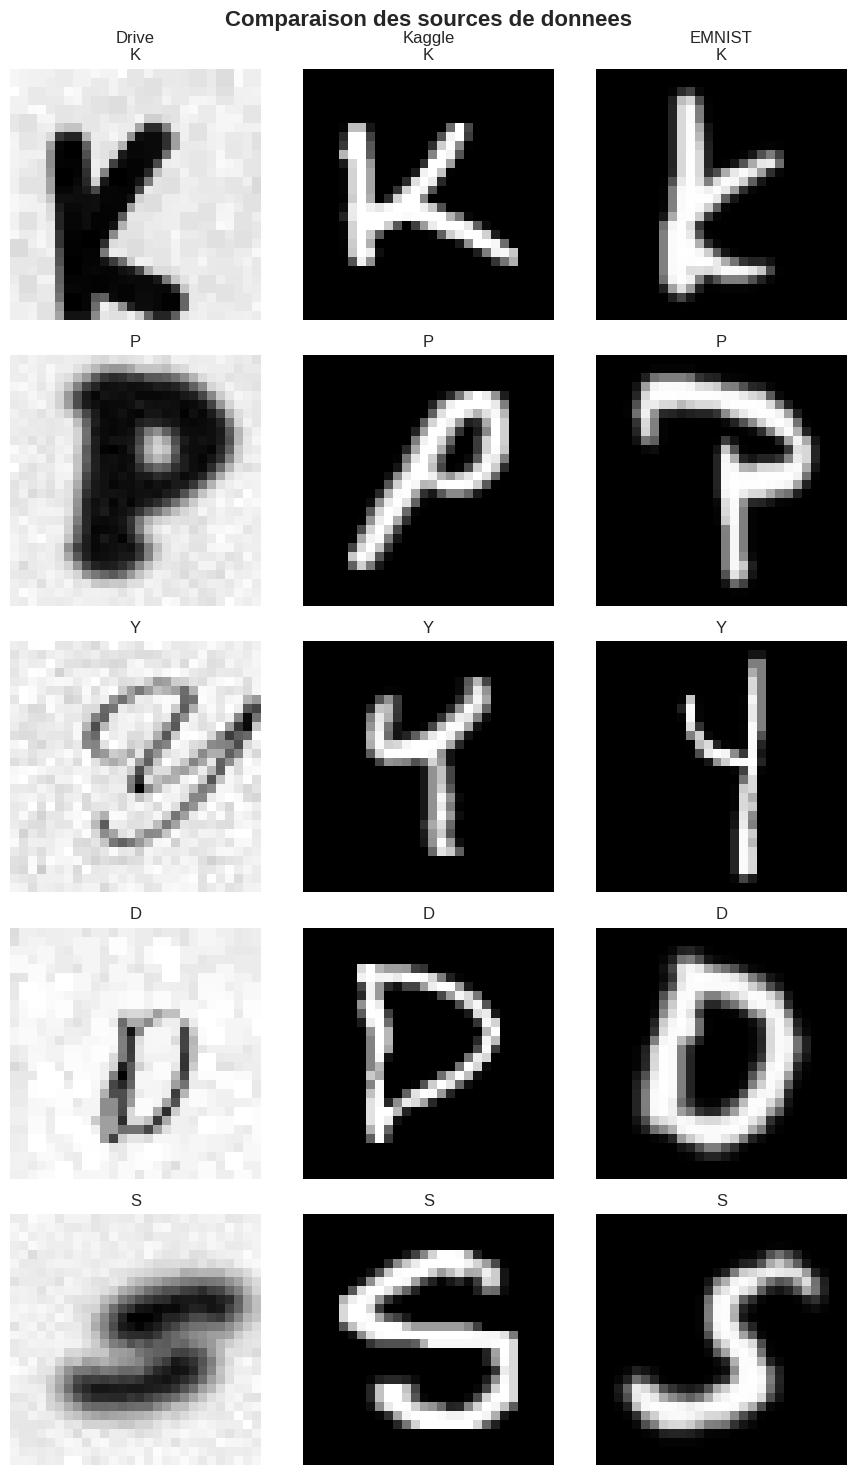

In [16]:
def compare_sources_visualization(datasets_dict):
    """
    Affiche une comparaison visuelle des differentes sources de donnees.
    Montre la meme lettre depuis chaque source pour verifier la coherence.

    Args:
        datasets_dict: Dictionnaire {nom: (X, y)} des datasets
    """
    n_sources = len(datasets_dict)
    n_letters = 5  # Nombre de lettres a afficher

    # Selection de lettres aleatoires
    letters_to_show = np.random.choice(26, n_letters, replace=False)

    fig, axes = plt.subplots(n_letters, n_sources, figsize=(3*n_sources, 3*n_letters))
    fig.suptitle('Comparaison des sources de donnees', fontsize=16, fontweight='bold')

    for col, (source_name, (X, y)) in enumerate(datasets_dict.items()):
        for row, letter_idx in enumerate(letters_to_show):
            ax = axes[row, col] if n_letters > 1 else axes[col]

            # Trouver une image avec ce label
            mask = (y == letter_idx)
            if mask.sum() > 0:
                indices = np.where(mask)[0]
                img_idx = np.random.choice(indices)
                ax.imshow(X[img_idx], cmap='gray')
                letter_char = chr(65 + letter_idx)
                ax.set_title(f'{source_name}\n{letter_char}' if row == 0 else letter_char)
            else:
                ax.text(0.5, 0.5, 'N/A', ha='center', va='center')

            ax.axis('off')

    plt.tight_layout()
    plt.show()


# Comparaison visuelle des trois sources
datasets_comparison = {
    'Drive': (X_drive, y_drive),
    'Kaggle': (X_kaggle, y_kaggle),
    'EMNIST': (X_emnist, y_emnist),
}
compare_sources_visualization(datasets_comparison)

---
# PARTIE 2: ENTRAINEMENT DU MODELE ICR_V3
---

## 14. Configuration GPU et Imports Deep Learning

In [17]:
# Configuration GPU et imports TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc

# Verification et configuration du GPU
print("=" * 60)
print("CONFIGURATION GPU")
print("=" * 60)

# Liste des GPUs disponibles
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs detectes: {len(gpus)}")

if gpus:
    try:
        # Activer la croissance memoire dynamique pour eviter l'allocation totale
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"  - {gpu.name}: Memory growth active")

        # Afficher les details du GPU
        print(f"\nDetails GPU:")
        print(f"  - CUDA disponible: {tf.test.is_built_with_cuda()}")
        print(f"  - GPU utilisable: {tf.test.is_gpu_available()}")

    except RuntimeError as e:
        print(f"Erreur configuration GPU: {e}")
else:
    print("Aucun GPU detecte - Utilisation du CPU")

# Configuration pour performances optimales
tf.keras.backend.clear_session()
gc.collect()

print(f"\nTensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


CONFIGURATION GPU
GPUs detectes: 1
  - /physical_device:GPU:0: Memory growth active

Details GPU:
  - CUDA disponible: True
  - GPU utilisable: True

TensorFlow version: 2.19.0
Keras version: 3.10.0


## 15. Preparation des Donnees pour l'Entrainement

In [18]:
# Preparation des donnees avec split 80/20 (Train/Validation)
print("=" * 60)
print("PREPARATION DES DONNEES POUR ENTRAINEMENT")
print("=" * 60)

# Nouveau split 80/20 pour l'entrainement
from sklearn.model_selection import train_test_split

X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_final, y_final,
    test_size=0.20,
    random_state=42,
    stratify=y_final
)

# Reshape pour CNN (N, 28, 28, 1)
X_train_model = X_train_final.reshape(-1, 28, 28, 1).astype(np.float32)
X_val_model = X_val_final.reshape(-1, 28, 28, 1).astype(np.float32)

# Conversion des labels en one-hot encoding
num_classes = 26
y_train_onehot = keras.utils.to_categorical(y_train_final, num_classes)
y_val_onehot = keras.utils.to_categorical(y_val_final, num_classes)

print(f"\nDonnees preparees:")
print(f"  - X_train: {X_train_model.shape} ({X_train_model.nbytes / (1024**3):.2f} GB)")
print(f"  - X_val:   {X_val_model.shape} ({X_val_model.nbytes / (1024**3):.2f} GB)")
print(f"  - y_train: {y_train_onehot.shape}")
print(f"  - y_val:   {y_val_onehot.shape}")
print(f"  - Nombre de classes: {num_classes}")

# Verification de la distribution
print(f"\nDistribution des classes:")
train_counts = np.bincount(y_train_final)
val_counts = np.bincount(y_val_final)
print(f"  - Train: min={train_counts.min()}, max={train_counts.max()}, mean={train_counts.mean():.0f}")
print(f"  - Val:   min={val_counts.min()}, max={val_counts.max()}, mean={val_counts.mean():.0f}")

PREPARATION DES DONNEES POUR ENTRAINEMENT

Donnees preparees:
  - X_train: (701640, 28, 28, 1) (2.05 GB)
  - X_val:   (175410, 28, 28, 1) (0.51 GB)
  - y_train: (701640, 26)
  - y_val:   (175410, 26)
  - Nombre de classes: 26

Distribution des classes:
  - Train: min=15826, max=56340, mean=26986
  - Val:   min=3956, max=14085, mean=6747


## 16. Architecture du Modele ICR_V3_Model

In [19]:
def create_icr_v3_model(input_shape=(28, 28, 1), num_classes=26):
    """
    Architecture Deep CNN ICR_V3_Model optimisee pour la reconnaissance de lettres manuscrites.

    Structure:
    - 4 blocs convolutionnels: Conv2D -> BatchNorm -> ReLU -> MaxPool
    - Filtres progressifs: 32 -> 64 -> 128 -> 256
    - Classifier: Flatten -> Dense -> Dropout(0.5) -> Softmax

    Args:
        input_shape: Dimensions d'entree (28, 28, 1)
        num_classes: Nombre de classes (26 pour A-Z)

    Returns:
        Modele Keras compile
    """
    model = models.Sequential(name='ICR_V3_Model')

    # =====================================================
    # BLOC 1: 32 filtres
    # =====================================================
    model.add(layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        padding='same',
        input_shape=input_shape,
        name='conv1'
    ))
    model.add(layers.BatchNormalization(name='bn1'))
    model.add(layers.ReLU(name='relu1'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool1'))
    # Output: (14, 14, 32)

    # =====================================================
    # BLOC 2: 64 filtres
    # =====================================================
    model.add(layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        name='conv2'
    ))
    model.add(layers.BatchNormalization(name='bn2'))
    model.add(layers.ReLU(name='relu2'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool2'))
    # Output: (7, 7, 64)

    # =====================================================
    # BLOC 3: 128 filtres
    # =====================================================
    model.add(layers.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        padding='same',
        name='conv3'
    ))
    model.add(layers.BatchNormalization(name='bn3'))
    model.add(layers.ReLU(name='relu3'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool3'))
    # Output: (3, 3, 128)

    # =====================================================
    # BLOC 4: 256 filtres
    # =====================================================
    model.add(layers.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        padding='same',
        name='conv4'
    ))
    model.add(layers.BatchNormalization(name='bn4'))
    model.add(layers.ReLU(name='relu4'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same', name='pool4'))
    # Output: (2, 2, 256)

    # =====================================================
    # CLASSIFIER (Fully Connected)
    # =====================================================
    model.add(layers.Flatten(name='flatten'))

    # Dense layer avec regularisation L2
    model.add(layers.Dense(
        units=512,
        kernel_regularizer=keras.regularizers.l2(0.001),
        name='dense1'
    ))
    model.add(layers.BatchNormalization(name='bn_dense'))
    model.add(layers.ReLU(name='relu_dense'))

    # Dropout agressif pour la robustesse
    model.add(layers.Dropout(rate=0.5, name='dropout'))

    # Couche de sortie: 26 classes (A-Z)
    model.add(layers.Dense(
        units=num_classes,
        activation='softmax',
        name='output'
    ))

    return model


# Creation du modele
print("=" * 60)
print("ARCHITECTURE ICR_V3_MODEL")
print("=" * 60)

model = create_icr_v3_model(input_shape=(28, 28, 1), num_classes=26)

# Affichage du resume de l'architecture
model.summary()

# Calcul du nombre de parametres
total_params = model.count_params()
print(f"\nNombre total de parametres: {total_params:,}")
print(f"Taille estimee du modele: {total_params * 4 / (1024**2):.2f} MB (float32)")

ARCHITECTURE ICR_V3_MODEL


Model: "ICR_V3_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (ReLU)                    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 7, 7, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (ReLU)                    │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 3, 3, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu4 (ReLU)                    │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense (BatchNormalization)   │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_dense (ReLU)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 929,946 (3.55 MB)

 Trainable params: 927,962 (3.54 MB)

 Non-trainable params: 1,984 (7.75 KB)


Nombre total de parametres: 929,946
Taille estimee du modele: 3.55 MB (float32)


## 17. Data Augmentation (Le Facteur X)

CONFIGURATION DATA AUGMENTATION

Data Augmentation configure:
  - Rotation: +/- 15 degres
  - Shift (H/V): +/- 10%
  - Zoom: +/- 10%
  - Shear: +/- 10%
  - Bruit gaussien: sigma=0.1
  - Batch size: 128
  - Steps par epoch (train): 5482
  - Steps par epoch (val): 1371

Visualisation des augmentations appliquees:


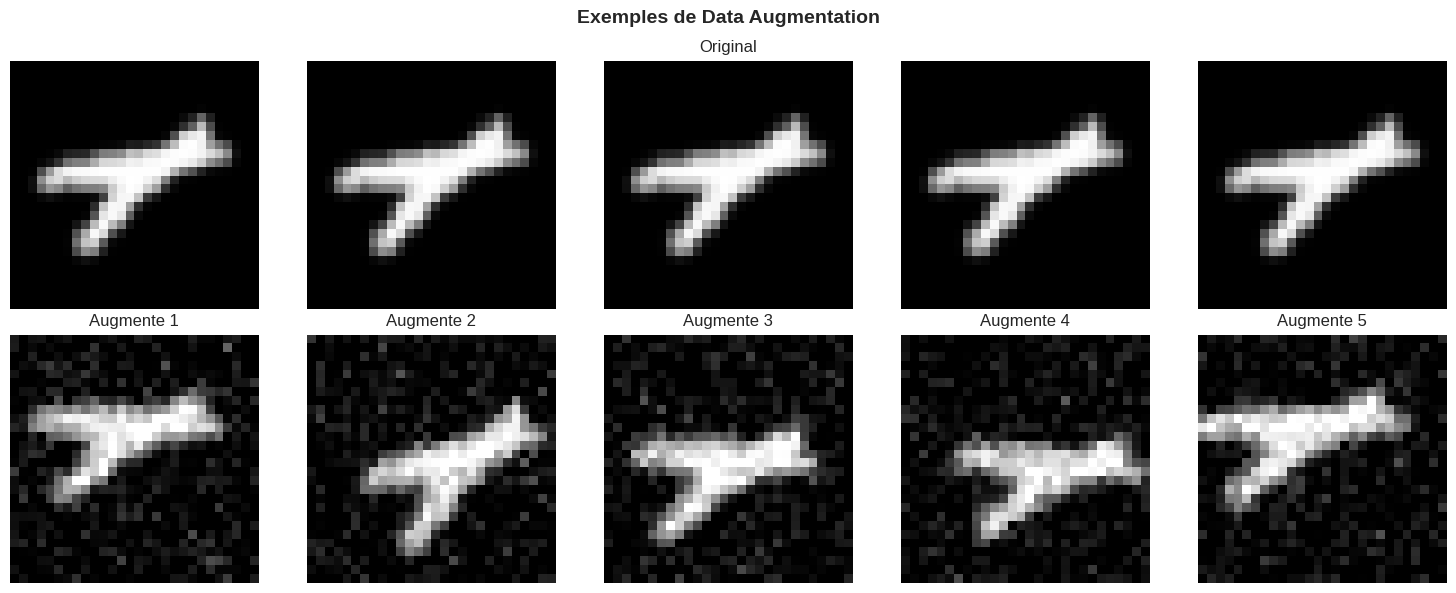

In [20]:
def add_noise(image):
    """
    Ajoute du bruit gaussien pour simuler du papier sale ou un scan de mauvaise qualite.

    Args:
        image: Image numpy array

    Returns:
        Image avec bruit ajoute
    """
    noise_factor = 0.1
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0.0, 1.0)


# Configuration du Data Augmentation pour l'entrainement
print("=" * 60)
print("CONFIGURATION DATA AUGMENTATION")
print("=" * 60)

# Generateur avec augmentation pour l'entrainement
train_datagen = ImageDataGenerator(
    # Rotation aleatoire de +/- 15 degres
    rotation_range=15,

    # Decalage horizontal et vertical (shift)
    width_shift_range=0.1,
    height_shift_range=0.1,

    # Zoom leger
    zoom_range=0.1,

    # Cisaillement (shear)
    shear_range=0.1,

    # Remplissage des pixels manquants
    fill_mode='nearest',

    # Fonction de preprocessing pour ajouter du bruit
    preprocessing_function=add_noise
)

# Generateur sans augmentation pour la validation (donnees intactes)
val_datagen = ImageDataGenerator()

# Creation des generateurs
batch_size = 128  # Optimise pour GPU T4 (16GB VRAM)

train_generator = train_datagen.flow(
    X_train_model, y_train_onehot,
    batch_size=batch_size,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val_model, y_val_onehot,
    batch_size=batch_size,
    shuffle=False
)

print(f"\nData Augmentation configure:")
print(f"  - Rotation: +/- 15 degres")
print(f"  - Shift (H/V): +/- 10%")
print(f"  - Zoom: +/- 10%")
print(f"  - Shear: +/- 10%")
print(f"  - Bruit gaussien: sigma=0.1")
print(f"  - Batch size: {batch_size}")
print(f"  - Steps par epoch (train): {len(train_generator)}")
print(f"  - Steps par epoch (val): {len(val_generator)}")

# Visualisation des augmentations
print("\nVisualisation des augmentations appliquees:")
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Exemples de Data Augmentation', fontsize=14, fontweight='bold')

# Image originale
sample_idx = np.random.randint(0, len(X_train_model))
original_img = X_train_model[sample_idx]

# Ligne 1: Image originale repetee
for i in range(5):
    axes[0, i].imshow(original_img.squeeze(), cmap='gray')
    axes[0, i].set_title('Original' if i == 2 else '')
    axes[0, i].axis('off')

# Ligne 2: Versions augmentees
sample_batch = original_img.reshape(1, 28, 28, 1)
for i in range(5):
    augmented = train_datagen.flow(sample_batch, batch_size=1)[0][0]
    axes[1, i].imshow(augmented.squeeze(), cmap='gray')
    axes[1, i].set_title(f'Augmente {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## 18. Configuration des Callbacks et Compilation

In [21]:
# Configuration des callbacks pour un entrainement robuste
print("=" * 60)
print("CONFIGURATION DES CALLBACKS")
print("=" * 60)

# Repertoire pour les checkpoints
import os
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# 1. ModelCheckpoint: Sauvegarde du meilleur modele uniquement
model_checkpoint = callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'ICR_V3_best_model.keras'),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# 2. ReduceLROnPlateau: Reduction du learning rate si stagnation
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,           # Divise le LR par 10
    patience=3,           # Attend 3 epochs sans amelioration
    min_lr=1e-7,          # LR minimum
    verbose=1
)

# 3. EarlyStopping: Arret anticipe si overfitting
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,           # Patience de 7 epochs
    restore_best_weights=True,
    verbose=1
)

# 4. TensorBoard pour le monitoring (optionnel)
tensorboard = callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True
)

# 5. Custom callback pour afficher les metriques
class TrainingMonitor(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = float(keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"\n  LR actuel: {lr:.2e}")

training_monitor = TrainingMonitor()

# Liste des callbacks
callbacks_list = [
    model_checkpoint,
    reduce_lr,
    early_stopping,
    tensorboard,
    training_monitor
]

print("Callbacks configures:")
print("  1. ModelCheckpoint: Sauvegarde meilleur modele (val_loss min)")
print("  2. ReduceLROnPlateau: LR / 10 si stagnation pendant 3 epochs")
print("  3. EarlyStopping: Arret si val_loss stagne pendant 7 epochs")
print("  4. TensorBoard: Logging pour visualisation")
print("  5. TrainingMonitor: Affichage du LR courant")

# Compilation du modele
print("\n" + "=" * 60)
print("COMPILATION DU MODELE")
print("=" * 60)

# Optimiseur Adam avec learning rate initial de 0.001
optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\nModele compile:")
print(f"  - Optimiseur: Adam")
print(f"  - Learning Rate initial: 0.001")
print(f"  - Loss: Categorical Crossentropy")
print(f"  - Metriques: Accuracy")

CONFIGURATION DES CALLBACKS
Callbacks configures:
  1. ModelCheckpoint: Sauvegarde meilleur modele (val_loss min)
  2. ReduceLROnPlateau: LR / 10 si stagnation pendant 3 epochs
  3. EarlyStopping: Arret si val_loss stagne pendant 7 epochs
  4. TensorBoard: Logging pour visualisation
  5. TrainingMonitor: Affichage du LR courant

COMPILATION DU MODELE

Modele compile:
  - Optimiseur: Adam
  - Learning Rate initial: 0.001
  - Loss: Categorical Crossentropy
  - Metriques: Accuracy


## 19. Entrainement du Modele

In [22]:
# Entrainement du modele ICR_V3
print("=" * 60)
print("ENTRAINEMENT DU MODELE ICR_V3")
print("=" * 60)

# Configuration de l'entrainement
max_epochs = 50
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

print(f"\nConfiguration:")
print(f"  - Max epochs: {max_epochs}")
print(f"  - Batch size: {batch_size}")
print(f"  - Steps per epoch (train): {steps_per_epoch}")
print(f"  - Validation steps: {validation_steps}")
print(f"  - Samples d'entrainement: {len(X_train_model):,}")
print(f"  - Samples de validation: {len(X_val_model):,}")

print(f"\nDemarrage de l'entrainement...")
print("=" * 60)

# Chronometre
import time
start_time = time.time()

# Entrainement avec Data Augmentation
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=max_epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list,
    verbose=1
)

# Calcul du temps total
end_time = time.time()
training_time = end_time - start_time

print("\n" + "=" * 60)
print("ENTRAINEMENT TERMINE")
print("=" * 60)
print(f"Duree totale: {training_time/3600:.2f} heures ({training_time/60:.1f} minutes)")
print(f"Nombre d'epochs effectues: {len(history.history['loss'])}")

ENTRAINEMENT DU MODELE ICR_V3

Configuration:
  - Max epochs: 50
  - Batch size: 128
  - Steps per epoch (train): 5482
  - Validation steps: 1371
  - Samples d'entrainement: 701,640
  - Samples de validation: 175,410

Demarrage de l'entrainement...
Epoch 1/50
5481/5482 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7556 - loss: 1.0913
Epoch 1: val_loss improved from inf to 0.41706, saving model to ./checkpoints/ICR_V3_best_model.keras

  LR actuel: 1.00e-03
5482/5482 ━━━━━━━━━━━━━━━━━━━━ 243s 43ms/step - accuracy: 0.7557 - loss: 1.0911 - val_accuracy: 0.9067 - val_loss: 0.4171 - learning_rate: 0.0010
Epoch 2/50
5481/5482 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8783 - loss: 0.5141
Epoch 2: val_loss improved from 0.41706 to 0.40121, saving model to ./checkpoints/ICR_V3_best_model.keras

  LR actuel: 1.00e-03
5482/5482 ━━━━━━━━━━━━━━━━━━━━ 224s 41ms/step - accuracy: 0.8783 - loss: 0.5141 - val_accuracy: 0.9113 - val_loss: 0.4012 - learning_rate: 0.0010
Epoch 3/50
5481/5482 ━━━━━━

## 20. Courbes d'Apprentissage (Loss et Accuracy)

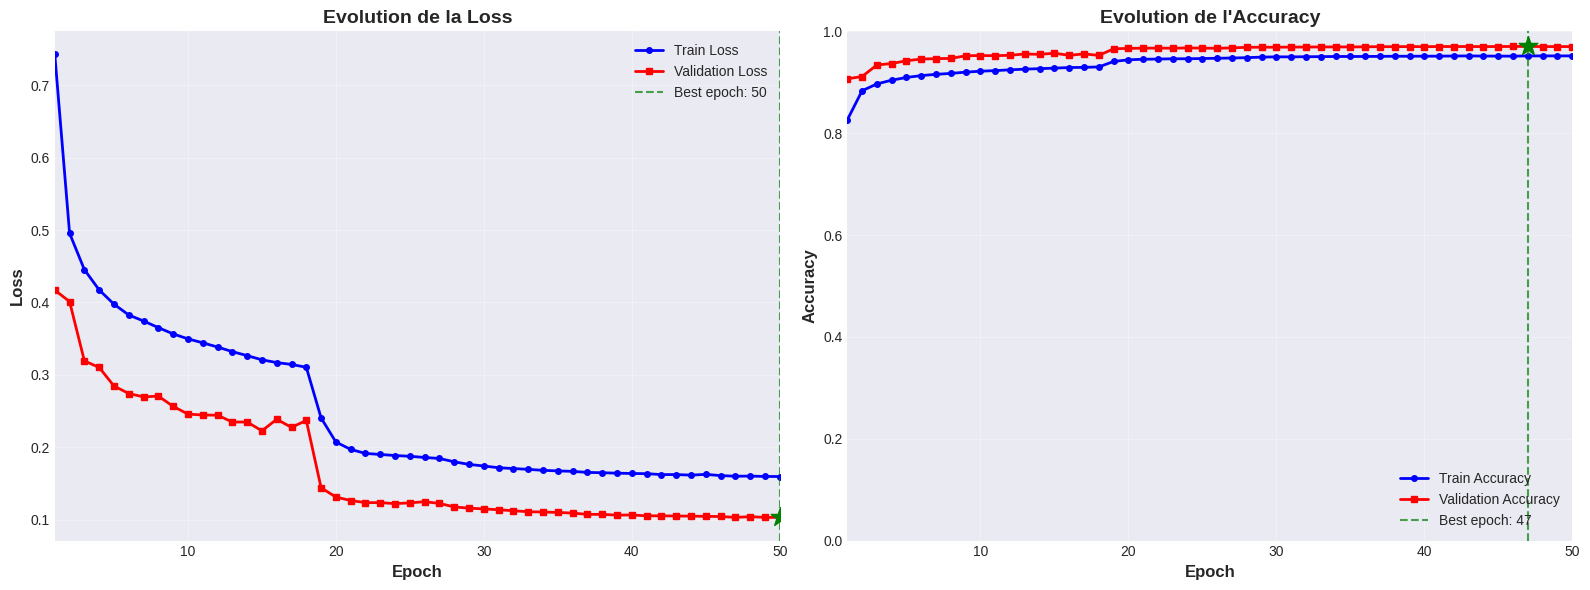


STATISTIQUES FINALES

Meilleure Validation Loss:
  - Epoch: 50
  - Val Loss: 0.1029
  - Train Loss: 0.1595

Meilleure Validation Accuracy:
  - Epoch: 47
  - Val Accuracy: 97.04%
  - Train Accuracy: 95.17%

Analyse du sur-apprentissage:
  - Gap (Train - Val): -1.83%
  - OK: Pas de sur-apprentissage significatif


In [23]:
def plot_training_history(history):
    """
    Affiche les courbes d'apprentissage (Loss et Accuracy).

    Args:
        history: Objet History retourne par model.fit()
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    epochs = range(1, len(history.history['loss']) + 1)

    # =====================================================
    # Graphique 1: Loss
    # =====================================================
    ax1 = axes[0]
    ax1.plot(epochs, history.history['loss'], 'b-', linewidth=2, label='Train Loss', marker='o', markersize=4)
    ax1.plot(epochs, history.history['val_loss'], 'r-', linewidth=2, label='Validation Loss', marker='s', markersize=4)

    # Marquer le meilleur point
    best_epoch = np.argmin(history.history['val_loss']) + 1
    best_val_loss = min(history.history['val_loss'])
    ax1.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best epoch: {best_epoch}')
    ax1.scatter([best_epoch], [best_val_loss], color='green', s=200, zorder=5, marker='*')

    ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax1.set_title('Evolution de la Loss', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim([1, len(epochs)])

    # =====================================================
    # Graphique 2: Accuracy
    # =====================================================
    ax2 = axes[1]
    ax2.plot(epochs, history.history['accuracy'], 'b-', linewidth=2, label='Train Accuracy', marker='o', markersize=4)
    ax2.plot(epochs, history.history['val_accuracy'], 'r-', linewidth=2, label='Validation Accuracy', marker='s', markersize=4)

    # Marquer le meilleur point
    best_epoch_acc = np.argmax(history.history['val_accuracy']) + 1
    best_val_acc = max(history.history['val_accuracy'])
    ax2.axvline(x=best_epoch_acc, color='green', linestyle='--', alpha=0.7, label=f'Best epoch: {best_epoch_acc}')
    ax2.scatter([best_epoch_acc], [best_val_acc], color='green', s=200, zorder=5, marker='*')

    ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Evolution de l\'Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim([1, len(epochs)])
    ax2.set_ylim([0, 1])

    plt.tight_layout()
    plt.savefig('./checkpoints/training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Affichage des statistiques finales
    print("\n" + "=" * 60)
    print("STATISTIQUES FINALES")
    print("=" * 60)
    print(f"\nMeilleure Validation Loss:")
    print(f"  - Epoch: {best_epoch}")
    print(f"  - Val Loss: {best_val_loss:.4f}")
    print(f"  - Train Loss: {history.history['loss'][best_epoch-1]:.4f}")

    print(f"\nMeilleure Validation Accuracy:")
    print(f"  - Epoch: {best_epoch_acc}")
    print(f"  - Val Accuracy: {best_val_acc*100:.2f}%")
    print(f"  - Train Accuracy: {history.history['accuracy'][best_epoch_acc-1]*100:.2f}%")

    # Verification du sur-apprentissage
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    gap = final_train_acc - final_val_acc

    print(f"\nAnalyse du sur-apprentissage:")
    print(f"  - Gap (Train - Val): {gap*100:.2f}%")
    if gap > 0.1:
        print("  - Attention: Sur-apprentissage detecte (gap > 10%)")
    else:
        print("  - OK: Pas de sur-apprentissage significatif")


# Affichage des courbes
plot_training_history(history)

## 21. Evaluation Finale et Matrice de Confusion

EVALUATION FINALE DU MODELE
Chargement du meilleur modele: ./checkpoints/ICR_V3_best_model.keras

Performances sur Validation:
  - Loss: 0.1029
  - Accuracy: 97.01%

Generation des predictions...

RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

           A       0.99      0.97      0.98      5894
           B       0.98      0.97      0.98      4854
           C       0.98      0.99      0.98      7802
           D       0.97      0.97      0.97      5147
           E       0.99      0.96      0.98      5408
           F       0.95      0.97      0.96      6353
           G       0.96      0.95      0.95      7272
           H       0.97      0.93      0.95      4564
           I       0.88      0.92      0.90      6344
           J       0.95      0.92      0.94      4819
           K       0.98      0.97      0.97      7240
           L       0.92      0.94      0.93      5437
           M       0.99      0.97      0.98      5587
           N       0

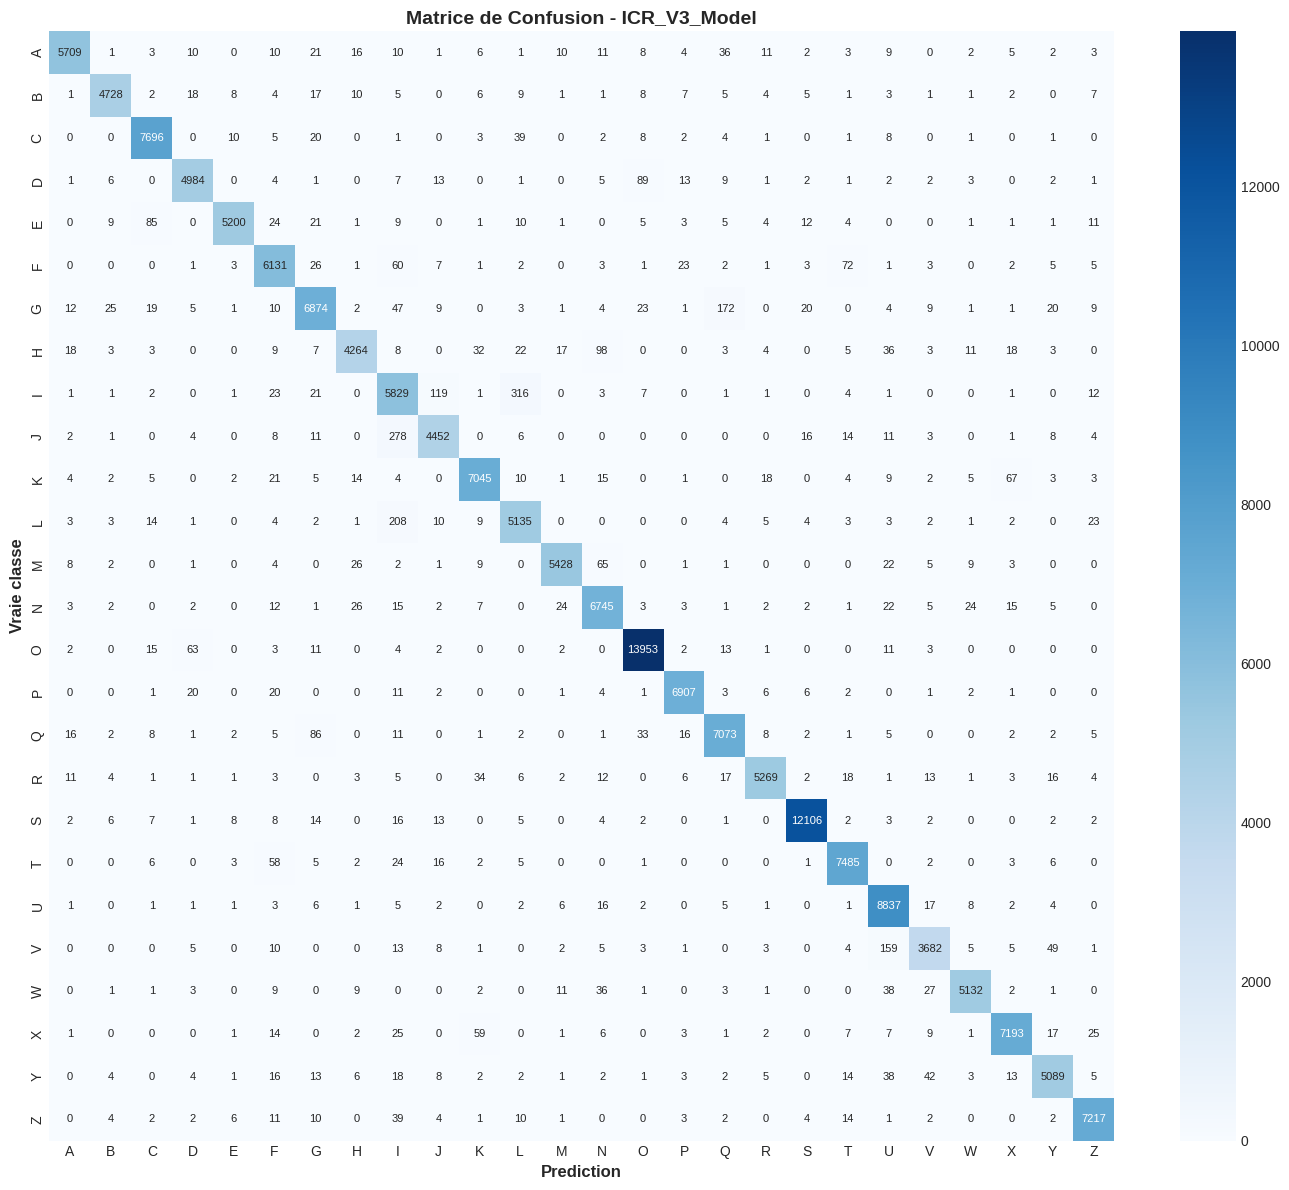


ANALYSE DES ERREURS

Top 5 des paires de lettres les plus confondues:
  I confondu avec L: 316 fois
  J confondu avec I: 278 fois
  L confondu avec I: 208 fois
  G confondu avec Q: 172 fois
  V confondu avec U: 159 fois


In [24]:
# Evaluation finale du modele
print("=" * 60)
print("EVALUATION FINALE DU MODELE")
print("=" * 60)

# Charger le meilleur modele sauvegarde
best_model_path = './checkpoints/ICR_V3_best_model.keras'
if os.path.exists(best_model_path):
    print(f"Chargement du meilleur modele: {best_model_path}")
    best_model = keras.models.load_model(best_model_path)
else:
    print("Utilisation du modele actuel (best weights restored)")
    best_model = model

# Evaluation sur le set de validation
val_loss, val_accuracy = best_model.evaluate(X_val_model, y_val_onehot, verbose=0)
print(f"\nPerformances sur Validation:")
print(f"  - Loss: {val_loss:.4f}")
print(f"  - Accuracy: {val_accuracy*100:.2f}%")

# Predictions
print("\nGeneration des predictions...")
y_pred_proba = best_model.predict(X_val_model, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Rapport de classification
from sklearn.metrics import classification_report, confusion_matrix

# Labels pour les classes
class_labels = [chr(65 + i) for i in range(26)]

print("\n" + "=" * 60)
print("RAPPORT DE CLASSIFICATION")
print("=" * 60)
print(classification_report(y_val_final, y_pred, target_names=class_labels))

# Matrice de confusion
print("\nGeneration de la matrice de confusion...")
cm = confusion_matrix(y_val_final, y_pred)

# Affichage de la matrice de confusion
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels,
    ax=ax,
    annot_kws={'size': 8}
)
ax.set_xlabel('Prediction', fontsize=12, fontweight='bold')
ax.set_ylabel('Vraie classe', fontsize=12, fontweight='bold')
ax.set_title('Matrice de Confusion - ICR_V3_Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./checkpoints/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Identification des classes les plus confondues
print("\n" + "=" * 60)
print("ANALYSE DES ERREURS")
print("=" * 60)

# Calcul des paires les plus confondues
np.fill_diagonal(cm, 0)  # Ignorer la diagonale
most_confused_indices = np.unravel_index(np.argsort(cm.ravel())[-5:], cm.shape)

print("\nTop 5 des paires de lettres les plus confondues:")
for i in range(4, -1, -1):
    true_class = class_labels[most_confused_indices[0][i]]
    pred_class = class_labels[most_confused_indices[1][i]]
    count = cm[most_confused_indices[0][i], most_confused_indices[1][i]]
    if count > 0:
        print(f"  {true_class} confondu avec {pred_class}: {count} fois")

## 22. Sauvegarde Finale et Export du Modele

In [25]:
# Sauvegarde finale du modele et des artefacts
print("=" * 60)
print("SAUVEGARDE FINALE DU MODELE")
print("=" * 60)

# Repertoire de sortie
output_dir = './model_export'
os.makedirs(output_dir, exist_ok=True)

# 1. Sauvegarde au format Keras natif (.keras)
keras_path = os.path.join(output_dir, 'ICR_V3_final.keras')
best_model.save(keras_path)
print(f"Modele Keras sauvegarde: {keras_path}")

# 2. Sauvegarde des poids uniquement
weights_path = os.path.join(output_dir, 'ICR_V3_weights.weights.h5')
best_model.save_weights(weights_path)
print(f"Poids sauvegardes: {weights_path}")

# 3. Export au format TensorFlow SavedModel (pour TensorFlow Serving)
savedmodel_path = os.path.join(output_dir, 'ICR_V3_savedmodel')
best_model.export(savedmodel_path)
print(f"SavedModel exporte: {savedmodel_path}")

# 4. Sauvegarde de l'historique d'entrainement
import json
history_path = os.path.join(output_dir, 'training_history.json')
with open(history_path, 'w') as f:
    json.dump(history.history, f, indent=2)
print(f"Historique sauvegarde: {history_path}")

# 5. Sauvegarde des metadonnees
metadata = {
    'model_name': 'ICR_V3_Model',
    'input_shape': (28, 28, 1),
    'num_classes': 26,
    'class_labels': class_labels,
    'training_samples': len(X_train_model),
    'validation_samples': len(X_val_model),
    'best_val_accuracy': float(max(history.history['val_accuracy'])),
    'best_val_loss': float(min(history.history['val_loss'])),
    'total_epochs': len(history.history['loss']),
    'training_time_seconds': training_time,
    'data_augmentation': {
        'rotation_range': 15,
        'width_shift_range': 0.1,
        'height_shift_range': 0.1,
        'zoom_range': 0.1,
        'shear_range': 0.1,
        'noise': True
    }
}

metadata_path = os.path.join(output_dir, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Metadonnees sauvegardees: {metadata_path}")

print("\n" + "=" * 60)
print("RESUME FINAL")
print("=" * 60)
print(f"\nModele: ICR_V3_Model")
print(f"Meilleure accuracy validation: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"Meilleure loss validation: {min(history.history['val_loss']):.4f}")
print(f"Temps d'entrainement: {training_time/60:.1f} minutes")
print(f"\nFichiers exportes dans: {output_dir}")
print("  - ICR_V3_final.keras (modele complet)")
print("  - ICR_V3_weights.weights.h5 (poids)")
print("  - ICR_V3_savedmodel/ (TensorFlow SavedModel)")
print("  - training_history.json (historique)")
print("  - model_metadata.json (metadonnees)")
print("\nModele pret pour le deploiement.")

SAUVEGARDE FINALE DU MODELE
Modele Keras sauvegarde: ./model_export/ICR_V3_final.keras
Poids sauvegardes: ./model_export/ICR_V3_weights.weights.h5
Saved artifact at './model_export/ICR_V3_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  139199031045648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139198978017232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139198973738064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139198973738256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139198978015312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139198973738448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139198973738832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139198978016464: TensorSpec(shape=(), dtype=tf.resource, name=N

## 23. Test de Prediction sur des Echantillons

TEST DE PREDICTION SUR ECHANTILLONS


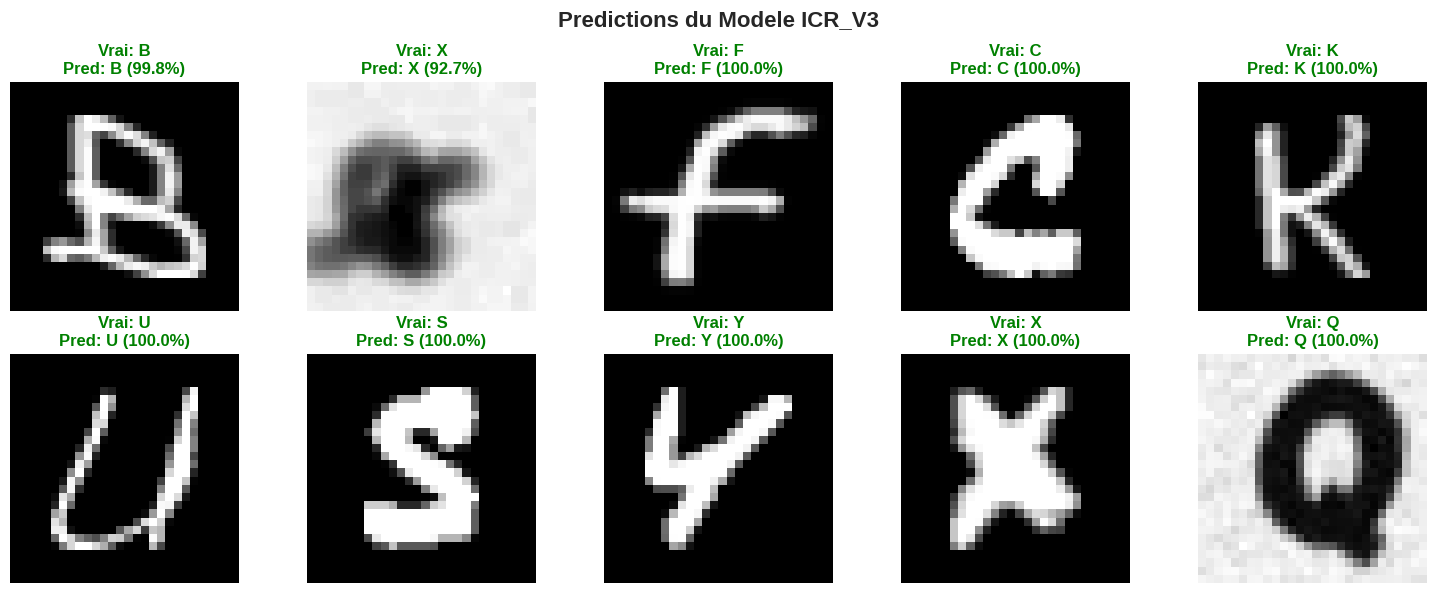


Predictions correctes: 10/10 (100%)


In [26]:
# Test de prediction sur des echantillons aleatoires
print("=" * 60)
print("TEST DE PREDICTION SUR ECHANTILLONS")
print("=" * 60)

# Selection de 10 echantillons aleatoires
n_samples = 10
indices = np.random.choice(len(X_val_model), n_samples, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Predictions du Modele ICR_V3', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    sample_idx = indices[idx]
    img = X_val_model[sample_idx]
    true_label = y_val_final[sample_idx]

    # Prediction
    pred_proba = best_model.predict(img.reshape(1, 28, 28, 1), verbose=0)
    pred_label = np.argmax(pred_proba)
    confidence = pred_proba[0][pred_label] * 100

    # Affichage
    ax.imshow(img.squeeze(), cmap='gray')

    true_char = chr(65 + true_label)
    pred_char = chr(65 + pred_label)

    # Couleur selon si la prediction est correcte
    color = 'green' if pred_label == true_label else 'red'

    ax.set_title(f'Vrai: {true_char}\nPred: {pred_char} ({confidence:.1f}%)',
                 color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig('./checkpoints/prediction_samples.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistiques sur les echantillons testes
correct = sum(1 for i in indices if y_val_final[i] == np.argmax(best_model.predict(X_val_model[i].reshape(1, 28, 28, 1), verbose=0)))
print(f"\nPredictions correctes: {correct}/{n_samples} ({correct/n_samples*100:.0f}%)")